<a href="https://colab.research.google.com/github/Andrewsas/trabalho-fundamentos-cid/blob/master/Modulo_4/Projeto_Final_Tratamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dependências

In [1]:
!pip install outlier_utils

In [33]:

import pandas as pd
import seaborn as sb
import plotly.offline as py
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from wordcloud import WordCloud, STOPWORDS
from outliers import smirnov_grubbs as grubbs
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 


#Obtenção de Dados

In [3]:
movies = pd.read_csv("https://github.com/Andrewsas/trabalho-fundamentos-cid/blob/master/data/movies.csv?raw=true")
series = pd.read_csv("https://github.com/Andrewsas/trabalho-fundamentos-cid/blob/master/data/series.csv?raw=true")
netflix = pd.read_csv("https://github.com/Andrewsas/trabalho-fundamentos-cid/blob/master/data/netflix_titles.csv?raw=true")

#Tratamento

In [4]:
# filter columns
movies['type'] = 'movie'
movies = movies[['type', 'release_date', 'title', 'popularity', 'vote_average', 'vote_count', 'genres', 'original_language', 'overview', 'Crew']]


In [5]:
# rename columns
movies.columns = ['type', 'release', 'title', 'popularity', 'vote_average', 'vote_count', 'genres', 'language', 'overview', 'crew']
movies.head()

,type,release,title,popularity,vote_average,vote_count,genres,language,overview,crew
0,movie,2020-11-19,Gabriel's Inferno Part III,33.315,8.8,725,Romance;Comedy,en,The final part of the film adaption of the ero...,Tosca Musk
1,movie,2020-07-31,Gabriel's Inferno Part II,9.365,8.8,1179,Romance,en,Professor Gabriel Emerson finally learns the t...,Tosca Musk
2,movie,1995-10-20,Dilwale Dulhania Le Jayenge,15.250,8.8,2663,Comedy;Drama;Romance,hi,"Raj is a rich, carefree, happy-go-lucky second...",Aditya Chopra
3,movie,2020-10-26,Wolfwalkers,28.370,8.7,258,Family;Adventure;Animation;Fantasy,en,"In a time of superstition and magic, when wolv...",Tomm Moore;Ross Stewart;Mark Mullery
4,movie,1994-09-23,The Shawshank Redemption,54.041,8.7,18389,Drama;Crime,en,Framed in the 1940s for the double murder of h...,Frank Darabont;Sioux Richards;Jesse V. Johnson...


In [6]:
# filter columns
series['type'] = 'serie'
series = series[['type', 'first_air_date', 'name', 'popularity', 'vote_average', 'vote_count', 'genres', 'original_language', 'overview', 'Crew']]


In [7]:
# rename columns
series.columns = ['type', 'release', 'title', 'popularity', 'vote_average', 'vote_count', 'genres', 'language', 'overview', 'crew']
series.head()

,type,release,title,popularity,vote_average,vote_count,genres,language,overview,crew
0,serie,2004-05-10,I Am Not an Animal,12.076,9.4,598,Animation;Comedy,en,I Am Not An Animal is an animated comedy serie...,NaN
1,serie,2019-07-12,Given,28.498,9.2,391,Animation;Drama,ja,"Tightly clutching his Gibson guitar, Mafuyu Sa...",Hikaru Yamaguchi
2,serie,2019-01-11,The Promised Neverland,65.812,9.2,545,Animation;Mystery;Sci-Fi & Fantasy;Action & Ad...,ja,"Surrounded by a forest and a gated entrance, t...",NaN
3,serie,2020-10-03,TONIKAWA: Over the Moon for You,32.649,9.1,176,Animation;Comedy,ja,"First comes marriage, then comes an earthbound...",Hiroshi Ikehata
4,serie,2019-01-09,The Rising of the Shield Hero,15.476,9.1,457,Animation;Action & Adventure;Sci-Fi & Fantasy;...,ja,Iwatani Naofumi was summoned into a parallel w...,Takao Abo


#Criação de Data Lake

In [8]:
# concatenar os dataset de filmes e series
data_lake = pd.concat([movies, series], ignore_index=True, sort=False)

In [9]:
# cast type columns
data_lake[['type', 'title', 'genres', 'language', 'overview', 'crew', 'release']] = data_lake[['type', 'title', 'genres', 'language', 'overview', 'crew', 'release']].astype('string')
data_lake[['popularity', 'vote_average']] = data_lake[['popularity', 'vote_average']].astype('float')
data_lake[['vote_count']] = data_lake[['vote_count']].astype('int')
data_lake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10102 entries, 0 to 10101
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   type          10102 non-null  string 
 1   release       10094 non-null  string 
 2   title         10102 non-null  string 
 3   popularity    10102 non-null  float64
 4   vote_average  10102 non-null  float64
 5   vote_count    10102 non-null  int64  
 6   genres        10077 non-null  string 
 7   language      10102 non-null  string 
 8   overview      10048 non-null  string 
 9   crew          8789 non-null   string 
dtypes: float64(2), int64(1), string(7)
memory usage: 789.3 KB


In [10]:
# verificando a possibilidade de existir dados duplicados
data_lake.loc[data_lake.duplicated(['title', 'type', 'release'])]

,type,release,title,popularity,vote_average,vote_count,genres,language,overview,crew


In [11]:
# removendo filmes e series sem data de lançamento
data_lake = data_lake.drop(data_lake.loc[data_lake['release'].isnull()].index)
data_lake = data_lake

##Tratamento de gêneros de filmes e séries

In [12]:
data_lake.loc[data_lake['genres'].isnull()][['title', 'release', 'genres']]

,title,release,genres
2697,Anplagghed al cinema,2006-11-26,<NA>
7258,Il pesce innamorato,1999-01-01,<NA>
8550,Shadow Hunter,2005-12-08,<NA>
8760,Les Contes de la rue Broca,1996-12-23,<NA>
8799,Club 57,2019-04-16,<NA>
8900,Atrévete a soñar,2009-03-08,<NA>
8908,Mi marido tiene mas familia,2018-07-23,<NA>
8977,La Fea Más Bella,2006-04-24,<NA>
9099,Pasión prohibida,2013-01-22,<NA>
9177,Hijas de la Luna,2018-02-19,<NA>


In [13]:
data_lake.loc[(data_lake['title'] == 'Anplagghed al cinema') & (data_lake['release'] == '2006-11-26'), 'genres'] = 'Comedy'
data_lake.loc[(data_lake['title'] == 'Il pesce innamorato') & (data_lake['release'] == '1999-01-01'), 'genres'] = 'Comedy'
data_lake.loc[(data_lake['title'] == 'Shadow Hunter') & (data_lake['release'] == '2005-12-08'), 'genres'] = 'Action;Romance;Drama'
data_lake.loc[(data_lake['title'] == 'Les Contes de la rue Broca') & (data_lake['release'] == '1996-12-23'), 'genres'] = 'Fantasy'
data_lake.loc[(data_lake['title'] == 'Club 57') & (data_lake['release'] == '2019-04-16'), 'genres'] = 'Comedy'
data_lake.loc[(data_lake['title'] == 'Atrévete a soñar') & (data_lake['release'] == '2009-03-08'), 'genres'] = 'Comedy'
data_lake.loc[(data_lake['title'] == 'Mi marido tiene mas familia') & (data_lake['release'] == '2018-07-23'), 'genres'] = 'Comedy'
data_lake.loc[(data_lake['title'] == 'La Fea Más Bella') & (data_lake['release'] == '2006-04-24'), 'genres'] = 'Comedy;Romance'
data_lake.loc[(data_lake['title'] == 'Pasión prohibida') & (data_lake['release'] == '2013-01-22'), 'genres'] = 'Drama'
data_lake.loc[(data_lake['title'] == 'Hijas de la Luna') & (data_lake['release'] == '2018-02-19'), 'genres'] = 'Comedy'
data_lake.loc[(data_lake['title'] == '100 días para enamorarnos') & (data_lake['release'] == '2020-04-28'), 'genres'] = 'Romance'
data_lake = data_lake.drop(data_lake.loc[(data_lake['title'] == 'Mi Marido Tiene Familia') & (data_lake['release'] == '2017-06-05')].index)
data_lake.loc[(data_lake['title'] == 'Amor Real') & (data_lake['release'] == '2003-06-09'), 'genres'] = 'Romance'
data_lake.loc[(data_lake['title'] == 'True Love') & (data_lake['release'] == '2012-09-03'), 'genres'] = 'Romance'
data_lake.loc[(data_lake['title'] == 'Las Tontas No Van al Cielo') & (data_lake['release'] == '2008-02-11'), 'genres'] = 'Romance'
data_lake.loc[(data_lake['title'] == 'La doble vida de Estela Carrillo') & (data_lake['release'] == '2017-02-13'), 'genres'] = 'Drama'
data_lake.loc[(data_lake['title'] == 'All For Love') & (data_lake['release'] == '2020-01-07'), 'genres'] = 'Romance'
data_lake.loc[(data_lake['title'] == 'Rosario Tijeras') & (data_lake['release'] == '2010-07-23'), 'genres'] = 'Drama'
data_lake.loc[(data_lake['title'] == 'Doña bella') & (data_lake['release'] == '2009-05-12'), 'genres'] = 'Romance'
data_lake.loc[(data_lake['title'] == 'Doña flor y sus dos maridos') & (data_lake['release'] == '2019-02-25'), 'genres'] = 'Comedy'
data_lake.loc[(data_lake['title'] == 'Ringo, la pelea de su vida') & (data_lake['release'] == '2019-01-23'), 'genres'] = 'Comedy'
data_lake.loc[(data_lake['title'] == 'Scream: The TV Series') & (data_lake['release'] == '2015-06-30'), 'genres'] = 'Comedy'


In [14]:
data_lake.loc[data_lake['genres'].isnull()][['title', 'release', 'genres']]

,title,release,genres


#Insights

In [15]:
def splitGeneros(x):
  list = x.replace('&', ';').split(";")
  for g in list:
    generos.append(g.strip())

In [16]:
# Criar lista de generos
generos = []

data_lake.apply(lambda x : splitGeneros(x['genres']),axis=1)

series = pd.Series(generos)

dt_generos = pd.DataFrame(series)
dt_generos['count'] = series.groupby(series).transform('count')

In [17]:
 dt_generos.columns = ['generos', 'count']
 dt_generos = dt_generos.drop_duplicates(subset=["generos", "count"])
 dt_generos.head()

,generos,count
0,Romance,1430
1,Comedy,3783
4,Drama,4788
6,Family,1117
7,Adventure,1837


##Distribuição dos gêneros.

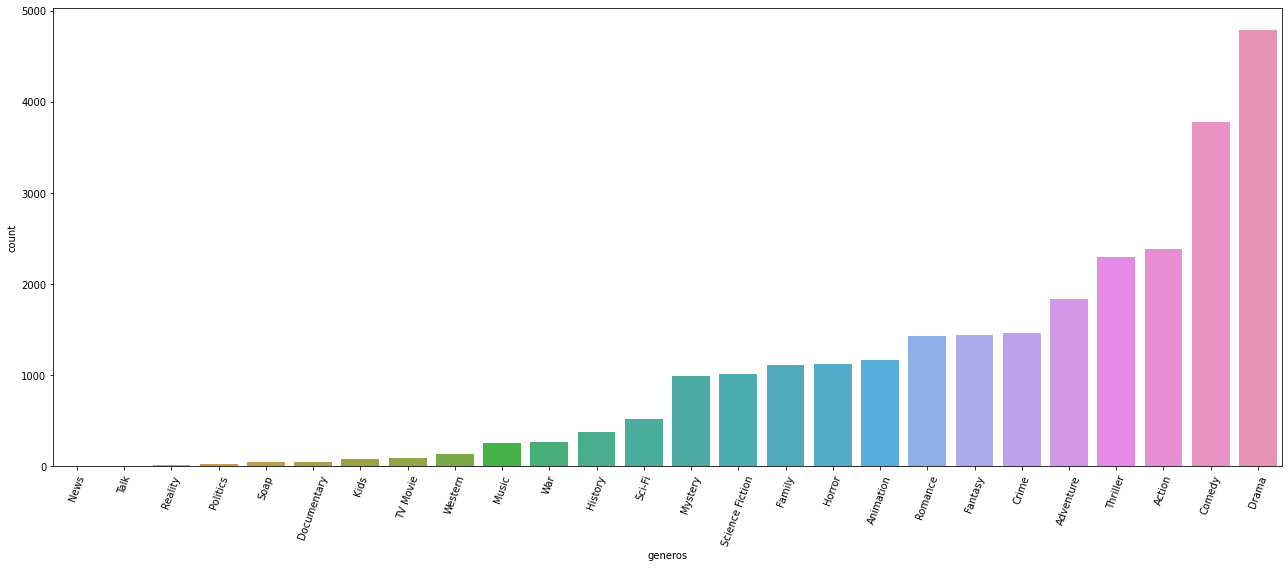

In [18]:
# verificar genero mais recorrentes no dataset
plt.figure(figsize=(18, 8))
sb.barplot(x='generos', y='count', data=dt_generos.sort_values('count'))
plt.xticks(rotation=70)
plt.tight_layout()

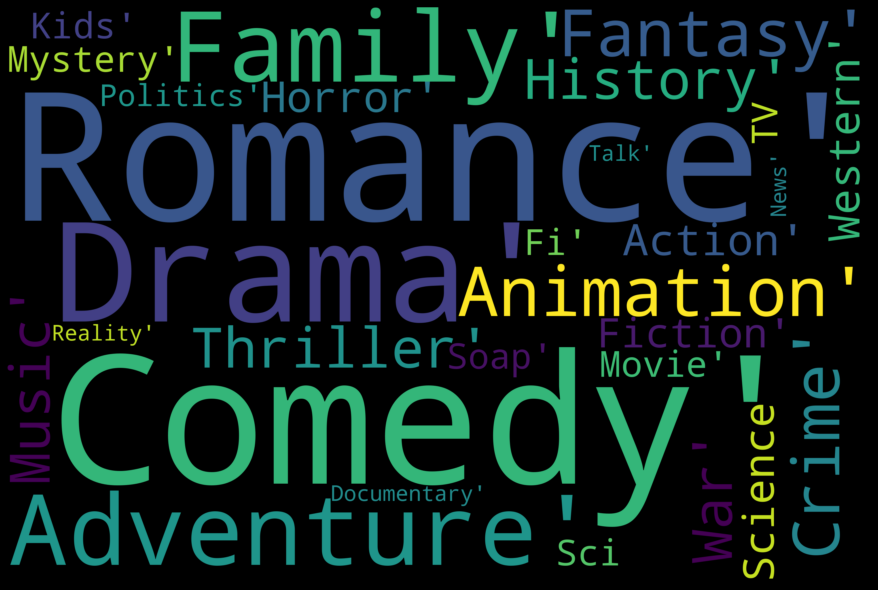

In [19]:
text = dt_generos['generos'].values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    collocations=False,
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (18, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [20]:
def evaluetionVote(x):
  if x>8:
      return 'Excelente'
  elif x<8 and x>6:
      return 'Bom'
  elif x<6 and x>4:
      return 'Regular'
  else: 
      return 'Ruim'

In [21]:
def evaluetionVoteQtd(x):
  if x>25000.000000:
      return 'Excelente'
  elif x<25000.000000 and x>10000.000000:
      return 'Bom'
  elif x<10000.000000 and x>5000.000000:
      return 'Regular'
  else: 
      return 'Ruim'

In [22]:
# Discretização da dados
data_lake['year_release'] = data_lake['release'].astype(str).str[0:4]
data_lake['vote_evaluation'] = data_lake.apply(lambda x : evaluetionVote(x['vote_average']),axis=1)
data_lake['vote_evaluation_qtd'] = data_lake.apply(lambda x : evaluetionVoteQtd(x['vote_count']),axis=1)

##Entendemos que dentre os gêneros dos filmes melhor avaliados, destacam-se para indicação os filmes que possuem comédia ou drama na sua classificação de gênero.

In [32]:
df_aux = data_lake.copy()
df_aux = df_aux[(df_aux['vote_evaluation'] == 'Excelente')&(df_aux['vote_evaluation_qtd'] == 'Excelente')]
df_aux['count'] = 0
df_aux = df_aux[['genres', 'count']].groupby(['genres']).count().reset_index()
df_aux = df_aux[df_aux['count'] > 5]

plt.figure(figsize=(10,8))
sb.barplot(x='count', y='genres', data=df_aux).set_title('count')

ValueError: ignored

<Figure size 720x576 with 0 Axes>

##Identificamos uma representação normal, os mais avaliados tiveram notas entre 7 e 9 pontos.

In [24]:
# verifica a correcao de nota e quantidade de votos
# identificamos uma representação normal, os mais avaliados tiveram notas entre 7 e 9 pontos
correlacao1 = data_lake[['vote_average', 'vote_count']]
trace = go.Scatter(x = correlacao1['vote_average'], y = correlacao1['vote_count'], mode="markers")

data = [trace]
py.iplot(data);

In [25]:
data_lake['popularity'].describe()

count    10093.000000
mean        25.213528
std         79.413398
min          0.600000
25%          9.199000
50%         12.626000
75%         22.077000
max       3936.862000
Name: popularity, dtype: float64

##Identificamos alguns outliers de popularidade. Poucos filmes e séries alcançam popularidade superior a mil, além disso, ter popularidade não é garantia de está bem avaliado.

In [26]:
# verifica a correcao de nota e popularidade
# identificamos que alguns outlines de popularidade poucos filmes e serie alcançam popularidade superior a 1k, e ter popualade não é garantia de está bem avaliado
correlacao2 = data_lake[['popularity', 'vote_average']]
trace = go.Scatter(y = correlacao2['popularity'], x = correlacao2['vote_average'], mode="markers")

data = [trace]
py.iplot(data);

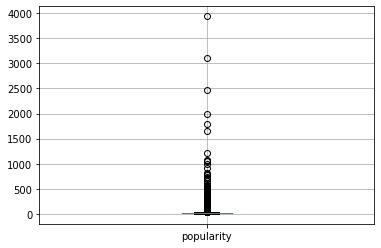

In [27]:
data_lake.boxplot(column=['popularity'])

## Avaliação de características de filmes e séries muito populares que possuem grande potencial de atrair novos usuários, mesmo avaliação dos votos não sendo a melhor no geral.

In [28]:
# verificando caracteristicas de filmes e serie muito populares
# grande potencial de atrair novos usuários mesmo a avaliação não sendo a melhor
data_lake.query('popularity > 1500').sort_values('popularity')

,type,release,title,popularity,vote_average,vote_count,genres,language,overview,crew,year_release,vote_evaluation,vote_evaluation_qtd
3032,movie,2020-12-16,Wonder Woman 1984,1657.673,6.9,3895,Fantasy;Action;Adventure,en,Wonder Woman comes into conflict with the Sovi...,Patty Jenkins;Dan Bradley;Toby Hefferman;Andy ...,2020,Bom,Ruim
8547,serie,2017-01-26,Riverdale,1786.489,8.6,10150,Mystery;Drama;Crime,en,"Set in the present, the series offers a bold, ...",<NA>,2017,Excelente,Bom
1728,movie,2021-02-05,Space Sweepers,1980.453,7.3,282,Drama;Fantasy;Science Fiction,ko,When the crew of a space junk collector ship c...,Jo Sung-hee;Han Gyeong-hoon;Shin Seung-gyun,2021,Bom,Ruim
5332,movie,2021-02-11,Red Dot,2477.143,6.3,215,Drama;Thriller,sv,"On a hiking trip to rekindle their marriage, a...",Alain Darborg,2021,Bom,Ruim
1912,movie,2020-12-03,Monster Hunter,3111.948,7.2,748,Fantasy;Action;Adventure,en,A portal transports Cpt. Artemis and an elite ...,Paul W. S. Anderson,2020,Bom,Ruim
8599,serie,2021-01-15,WandaVision,3936.862,8.5,6007,Sci-Fi & Fantasy;Mystery;Drama,en,Wanda Maximoff and Vision—two super-powered be...,<NA>,2021,Excelente,Regular


In [29]:
# Teste de Grubb
# comprovação de outlines
grubbs.max_test_indices(data_lake['popularity'], alpha=.05)

[8599, 1912]

##PCA

In [36]:
data = data_lake[['title', 'release' ,'vote_evaluation' , 'vote_evaluation_qtd' , 'popularity', 'vote_average', 'vote_count']]

df_remove = data.loc[(data['popularity'].isna() == True)|(data['vote_average'].isna() == True)|(data['vote_count'].isna() == True)]

dfr = data.drop(df_remove.index).reset_index()

dfr_title = dfr[['title', 'release' ,'vote_evaluation' , 'vote_evaluation_qtd']]

dfr_n=MinMaxScaler().fit_transform(dfr[['popularity', 'vote_average', 'vote_count']])

dfr_n

array([[8.31118457e-03, 9.31818182e-01, 2.20054926e-02],
       [2.22673186e-03, 9.31818182e-01, 3.79902824e-02],
       [3.72180510e-03, 9.31818182e-01, 9.02401239e-02],
       ...,
       [7.37908198e-03, 4.65909091e-01, 1.40835152e-04],
       [6.75259929e-03, 3.63636364e-01, 2.28857123e-03],
       [1.22070126e-03, 0.00000000e+00, 1.09147243e-03]])

In [37]:
pca = PCA(n_components=3)

components_principais = pca.fit_transform(dfr_n)

pompPrintDf = pd.DataFrame(data=components_principais, columns = ['pca1', 'pca2', 'pca3'])

finalDf = pd.concat([pompPrintDf, dfr_title], axis=1)

finalDf

,pca1,pca2,pca3,title,release,vote_evaluation,vote_evaluation_qtd
0,-0.215729,-0.088846,-0.001177,Gabriel's Inferno Part III,2020-11-19,Excelente,Ruim
1,-0.220264,-0.073748,-0.007811,Gabriel's Inferno Part II,2020-07-31,Excelente,Ruim
2,-0.235655,-0.023795,-0.008128,Dilwale Dulhania Le Jayenge,1995-10-20,Excelente,Ruim
3,-0.200007,-0.101242,-0.001668,Wolfwalkers,2020-10-26,Excelente,Ruim
4,-0.387737,0.508737,-0.017275,The Shawshank Redemption,1994-09-23,Excelente,Bom
...,...,...,...,...,...,...,...
10088,0.213502,0.023042,0.004736,Big Brother,2000-07-05,Regular,Ruim
10089,0.223624,0.028369,0.011907,Keeping Up with the Kardashians,2007-10-14,Regular,Ruim
10090,0.235894,0.027455,0.006625,Super Sentai,1975-04-05,Regular,Ruim
10091,0.333001,0.059608,0.007676,EastEnders,1985-02-19,Ruim,Ruim
